# **Proyecto Final:**
# **Detección de fraudes potenciales en las licitaciones públicas de Chile en el 2020 usando redes bipartitas y el coeficiente de Jaccard**

## Ciencias de Redes
### Profesor: Cristian Candia Vallejos
### Grupo 5:
- Carlos Bustamante
- Pablo Elgueta
- Patricio Ramirez
- Victor Ortiz

---

## Introducción

Una licitación es un proceso administrativo efectuado por un organismo comprador, el cual invita a diferentes proveedores interesados en proporcionar un bien o servicio a realizar una oferta, adeptándose así la más conveniente según los criterios de evaluación descritos en las bases (Mercado público, s.f.). Este proceso es muy vulnerable a la corrupción, debido a que esta puede darse en diferentes etapas y es difícil detectarla. Los principales indicadores de que una licitación podría ser fraudulenta son:

- Reducido número de licitadores
- Ofertas incoherentes de un mismo licitador.
- Similitudes sospechosas entre las ofertas.
- Ofertas no competitivas.
- Patrones de comportamiento similar entre las empresas licitadoras.
- Subcontratación no justificada entre empresas licitadoreas.
- Ofertas presentadas por las mismas personas físicas.
- Ofertas económicas de indéntica redacción, formato o errores.
- Uniones temporales de empresas licitadoras sin justificación aparente.
(Comisión Nacional de los Mercados y la Competencia, 2019)

Para el desarrollo de este trabajo se utilizaron los datos abiertos del portal Chile Compra (https://datos-abiertos.chilecompra.cl/), específicamente los registros del año 2020. Se busca identificar patrones de posibles fraudes utilizando herramientas de análisis de redes. Para conseguir esto, el trabajo se desarrolló en las siguientes etapas:

* Contexto del proyecto.
* Objetivos general, específicos e hipótesis formulada.   
* Análisis exploratorio. 
* Inferencia de la red.
* Descripción de la red.
* Identificación de patrones de corrupción.
* Conclusiones, trabajos futuros y limitaciones.

---

## Contexto del proyecto

Se seleccionaron las licitaciones del año 2020 debido a la sensibilidad que estas tenían respecto a la pandemia, el equipo encargado de desarrollar este proyecto supone que al haber sido una contingencia tan grande, quizás las barreras de control fueron más bajas. En el pasado distintas empresas se han visto envueltas en licitaciones polémicas, por ejemplo LG Electronics y el caso de luminarias públicas en el sur de Chile (CIPER, 2015), los casos PagoGate y MilicoGate (El Mostrador, 2019) y un sinfín de otros organismos tanto públicos como privados.

La base de datos contiene las siguientes columnas:

* Codigo: número único de licitación.                      
* Tipo de Adquisicion: rango del monto de la licitación.
* Estado: si la licitación se declaró adjudicada, desierta, revocada, cerrada o suspendida.
* CodigoOrganismo: número único del organismo público que abre una licitación. 
* NombreOrganismo: nombre del organismo público que abre la licitación.
* RutUnidad: rol único tributario de la unidad que participa en la licitación.
* ComunaUnidad: nombre de la comuna en la que la licitación es requerida.
* FechaPublicacion: fecha en la que la licitación se publicó.
* CodigoProductoONU: sistema de codificación común de las naciones unidas.
* RutProveedor: rol único tributario de la empresa que postula a la licitación.
* NombreProveedor: nombre de la empresa que se postula a la licitación.
* Moneda de la Oferta: divisa en la que se expresa el monto a pagar de la licitación.
* MontoLineaAdjudica: monto que se adjudica la empresa en la licitación, puede ser total o parcial.
* Oferta seleccionada: indicador booleando que expresa si la oferta efectuada por la empresa fue seleccionada o no.

## Objetivos general, específicos e hipótesis formulada

**Objetivo General**

Encontrar patrones de fraude y corrupción en las licitaciones públicas de Chile registradas en el año 2020.

**Objetivos Específicos**

- Desarrollo de una red bipartita que integre organismos y empresas.
- Identificar la componente gigante de la red.
- Identificar patrones de corrupción usando herramientas de análisis de redes complejas.

**Hipótesis Formulada**

¿Existe una relación que se repita de forma sostenida entre Organismos Públicos con los Proveedores para el periodo a analizar (2020)?.  

- La hipótesis del grupo es que la cantidad de interacciones entre un organismo y un proveedor respecto del global es un idicador de fraude.

- El hecho de que pocos proveedores se postulen a un concurso público, podría sugerir que el organismo no está publicando de manera justa sus licitaciones.



## Análisis exploratorio

In [1]:
# Librerías

#Matemática y datos
import pandas as pd
import numpy as np

#Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#Redes
import networkx as nx
from networkx.algorithms import bipartite
import community
from community import community_louvain


In [2]:
# Leer datos

df = pd.read_csv('lic2020_hackaton.csv', sep=',', encoding='latin_1')
df['FechaPublicacion']=pd.to_datetime(df['FechaPublicacion'])
df.head(3)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada


En primer lugar se debe analizar el contenido y eliminar aquellas filas que contuvieran datos nulos. Esto debido a que al momento de querer enlazar nodos o identificar patrones comunes estos datos quedan vinculados.

In [3]:
df.isnull().sum()

Codigo                      0
Tipo de Adquisicion         0
Estado                      0
CodigoOrganismo             0
NombreOrganismo             0
RutUnidad                   0
ComunaUnidad           111298
FechaPublicacion            0
CodigoProductoONU           0
RutProveedor                0
NombreProveedor          1860
Moneda de la Oferta         0
MontoLineaAdjudica          0
Oferta seleccionada         0
dtype: int64

In [4]:
df[df['NombreProveedor'].isnull()].head(3)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
4068,8621395,Licitación Pública Menor a 100 UTM (L1),Adjudicada,99860,MUNICIPALIDAD DE OVALLE,69.040.700-0,Ovalle,2020-01-13,25172301,76.690.208-1,NaN,Peso Chileno,1200000,Seleccionada
4190,8621461,Licitación Pública Menor a 100 UTM (L1),Adjudicada,99860,MUNICIPALIDAD DE OVALLE,69.040.700-0,Ovalle,2020-01-13,25172901,76.690.208-1,NaN,Peso Chileno,0,No Seleccionada
4192,8621461,Licitación Pública Menor a 100 UTM (L1),Adjudicada,99860,MUNICIPALIDAD DE OVALLE,69.040.700-0,Ovalle,2020-01-13,15121501,76.690.208-1,NaN,Peso Chileno,0,No Seleccionada


In [5]:
df = df.dropna()
df.isnull().sum()

Codigo                 0
Tipo de Adquisicion    0
Estado                 0
CodigoOrganismo        0
NombreOrganismo        0
RutUnidad              0
ComunaUnidad           0
FechaPublicacion       0
CodigoProductoONU      0
RutProveedor           0
NombreProveedor        0
Moneda de la Oferta    0
MontoLineaAdjudica     0
Oferta seleccionada    0
dtype: int64

- De acuerdo a la información contenida en el dataframe, es posible identificar que claramente existen 2 grupos de nodos. 

-Los primeros con sus datos agrupados en las columnas de la izquierda, corresponden a los organismos públicos que generan las licitaciones.


- En las columnas de la derecha figura lo referente a las empresas proveedoras que participan de las licitaciones asociadas a los organismos públicos, estableciéndose de este modo los enlaces para esta red bipartita.


- Identificados los grupos de nodos de la red bipartita, se procede a definir las columnas a utilizar de las que se extraerán estos, si utilizar códigos o nombres. Dado que en los Organismos las cantidades de Nombres son inferiores a las de Códigos, se opta por utilizar los Nombres, ya que eventualmente podría existir más de un Código asociado a los organismos, lo cual generaría una distorsión en el análisis al momento de establecer relaciones.

    

In [6]:
print('Cantidad de Nombres de Organismo:')
print(len(df['NombreOrganismo'].unique()))
print('\nCantidad de Codigos de Organismo:')
print(len(df['CodigoOrganismo'].unique()))

Cantidad de Nombres de Organismo:
859

Cantidad de Codigos de Organismo:
871


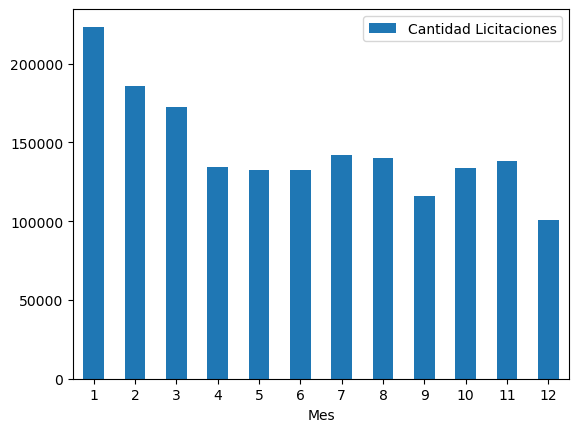

In [7]:
# Cantidad de Licitaciones abiertas por mes

df11 = df[df.Codigo.duplicated(keep=False)]
df11 = df11['FechaPublicacion'].dt.date.value_counts().sort_index().reset_index()
df11.columns=['Fecha Publicacion','Codigo']
df11['Fecha Publicacion']=pd.to_datetime(df11['Fecha Publicacion'])
df11['month'] = df11['Fecha Publicacion'].dt.month
df12 = df11.groupby(df11['Fecha Publicacion'].dt.month)['Codigo'].sum()
df12 = df12.to_frame().reset_index()
df12.columns = ['Mes', 'Cantidad Licitaciones']
ax = df12.plot.bar(x='Mes', y='Cantidad Licitaciones', rot=0)

Observando la distribución de  la cantidad de licitaciones durante el año, se puede observar una tendencia negativa, la cual no presentó mayores variaciones entre un mes y otro, a excepción de los primeros 3 meses del año. Esta variación no es significativa como para centrar incialmente un análisis en este punto.

In [8]:
# Cantidad total de veces que algún proveedor aplicó a alguna licitación

df13 = df['NombreProveedor'].value_counts().to_frame().reset_index()
df13['NombreProveedor'].sum()

1769860

In [9]:
# Top proveedores que más aplicaron a licitaciones

df13['Porcentaje del total'] = df13['NombreProveedor']/1769860
df13.rename(columns = {'index':'Proveedor','NombreProveedor':'Conteo'}, inplace = True)
df13[:15]

,Proveedor,Conteo,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,56023,0.031654
1,Socofar Division Munnich,46353,0.026190
2,Caribean Pharma Ltda,43473,0.024563
3,Distribuidora Salcobrand,36489,0.020617
4,WINPHARM,34765,0.019643
5,Medikar Ltda,30318,0.017130
6,DROGUERIA GLOBAL PHARMA SPA,29200,0.016498
7,LABOFAR,22592,0.012765
8,COMERCIALIZADORA ILHABELLA EIRL,22505,0.012716
9,LABORATORIO CHILE S.A.,20346,0.011496


Tal como se aprecia en la tabla, ninguno de los proveedores concentra un alto porcentaje de participación en licitaciones como para iniciar un análisis respecto a estos valores.

In [10]:
# Cantidad total de veces que algún organismo abrió una licitación

df14 = df['NombreOrganismo'].value_counts().to_frame().reset_index()
df14['NombreOrganismo'].sum()

1769860

In [11]:
# Top Organismos que más licitaciones abrieron

df14['Porcentaje del total'] = df14['NombreOrganismo']/1769860
df14.rename(columns = {'index':'Organismo','NombreOrganismo':'Conteo'}, inplace = True)
df14[:15]

,Organismo,Conteo,Porcentaje del total
0,FUERZA AEREA DE CHILE COMANDO LOGISTICO,43210,0.024414
1,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,35290,0.019939
2,COMANDO DE APOYO A LA FUERZA,34835,0.019682
3,DIRECCION DE ABASTECIMIENTO DE LA ARMADA,26760,0.015120
4,I MUNICIPALIDAD DE LOTA,24925,0.014083
5,SERVICIO DE SALUD VALDIVIA HOSPITAL BASE,23619,0.013345
6,INSTITUTO DE SALUD PUBLICA DE CHILE,22295,0.012597
7,DIRECCION GENERAL DE GENDARMERIA DE CHIL,20607,0.011643
8,I MUNICIPALIDAD DE LA PINTANA,19980,0.011289
9,I MUNICIPALIDAD VALDIVIA,17312,0.009782


En general es posible apreciar que no existe una entidad que concentre un porcentaje de licitaciones significativamente mayor a las demás como para ser objeto de análisis. 

In [12]:
# Conteo de ofertas seleccionadas

df15 = df['Oferta seleccionada'].value_counts().to_frame().reset_index()
df15.rename(columns = {'Oferta seleccionada':'Conteo','index':'Selección ofta'},inplace = True)
df15

,Selección ofta,Conteo
0,No Seleccionada,1409938
1,Seleccionada,359922


In [13]:
# Top proveedores que más fueron seleccionados

df15 = df[df['Oferta seleccionada'] == 'Seleccionada']
df15 = df15['NombreProveedor'].value_counts().to_frame().reset_index()
df15['Porcentaje del total'] = df15['NombreProveedor']/359922
df15.rename(columns = {'index':'Proveedor','NombreProveedor':'Conteo'}, inplace = True)
df15[:15]

,Proveedor,Conteo,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,8624,0.023961
1,Caribean Pharma Ltda,7468,0.020749
2,Socofar Division Munnich,6066,0.016854
3,LABORATORIO CHILE S.A.,5974,0.016598
4,LABORATORIOS RECALCINE S.A,4870,0.013531
5,DROGUERIA GLOBAL PHARMA SPA,4756,0.013214
6,VALTEK S.A.,3833,0.010650
7,LABORATORIOS ANDROMACO S.A.,3245,0.009016
8,Distribuidora Salcobrand,3156,0.008769
9,MAYORDENT LTDA,3082,0.008563


Dentro de los proveedores con mayor cantidad de adjudicaciones se aprecia que predominan aquellos vinculados a la industria farmacéutica, sin embargo, individualmente ninguno arroja un porcentaje lo suficientemente grande apra ser objeto de análisis.

In [14]:
# Conteo del estado de la oferta

df16 = df['Estado'].value_counts().to_frame().reset_index()
df16.rename(columns = {'Estado':'Conteo','index':'Estado'},inplace = True)
df16

,Estado,Conteo
0,Adjudicada,1633154
1,Desierta (o art. 3 ó 9 Ley 19.886),75018
2,Revocada,32108
3,Cerrada,29503
4,Suspendida,77


In [15]:
# Top proveedores que más licitaciones se adjudicaron

df16 = df[df['Estado'] == 'Adjudicada']
df16 = df16['NombreProveedor'].value_counts().to_frame().reset_index()
df16['Porcentaje del total'] = df16['NombreProveedor']/1633154
df16.rename(columns = {'index':'Proveedor','NombreProveedor':'Conteo'}, inplace = True)
df16[:15]

,Proveedor,Conteo,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,53671,0.032863
1,Socofar Division Munnich,43958,0.026916
2,Caribean Pharma Ltda,41971,0.025699
3,Distribuidora Salcobrand,35137,0.021515
4,WINPHARM,33047,0.020235
5,Medikar Ltda,29319,0.017952
6,DROGUERIA GLOBAL PHARMA SPA,28048,0.017174
7,LABOFAR,21815,0.013358
8,COMERCIALIZADORA ILHABELLA EIRL,20891,0.012792
9,LABORATORIO CHILE S.A.,19765,0.012102


In [16]:
df_te= df13.merge(df15, how='inner', on='Proveedor')
df_te = df_te[df_te['Conteo_y'] > 1000]
df_te['Tasa éxito'] = df_te['Conteo_y'] / df_te['Conteo_x']
df_te = df_te.reset_index().sort_values(by='Tasa éxito', ascending=False)
df_te.rename(columns = {'Conteo_x':'Conteo Postulaciones','Porcentaje del total_x':'% del total Postulaciones',
                       'Conteo_y':'Conteo Seleccionadas','Porcentaje del total_y':'% del total Seleccionadas'}, inplace = True)
df_te

,index,Proveedor,Conteo Postulaciones,% del total Postulaciones,Conteo Seleccionadas,% del total Seleccionadas,Tasa éxito
40,87,Roche Chile Ltda. Roche Diagnostics,2661,0.001504,2206,0.006129,0.829012
43,142,STRYKER CORPORATION CHILE Y COMPANIA LIMITADA,1662,0.000939,1055,0.002931,0.634777
42,138,BADEX,1705,0.000963,1015,0.002820,0.595308
23,33,VALTEK S.A.,6481,0.003662,3833,0.010650,0.591421
31,49,LABORATORIO SANDERSON S.A.,4517,0.002552,2542,0.007063,0.562763
33,56,MOSIL LIMITADA,4034,0.002279,2257,0.006271,0.559494
37,71,Laboratorio Pasteur SA,3175,0.001794,1668,0.004634,0.525354
39,80,Fresenius Kabi Chile Ltda.,2891,0.001633,1412,0.003923,0.488412
34,58,Johnson & Johnson Medical,3815,0.002156,1810,0.005029,0.474443
38,77,Merck S.A. Productos Químicos,3028,0.001711,1413,0.003926,0.466645




- Del análisis de datos, fue posible identificar que existen 2 grupos de nodos mediante los cuales es factible generar una Red Bipartita. El primer Grupo contempla las primeras columnas de datos que se encuentras asociadas a los Organismos estatales que generan las Licitaciones. Por otro lado, el conjunto de columnas de la izquierda corresponden a las Empresas participantes de las licitaciones.

- Dentro del análisis exploratiorio de los datos, fue posible identificar que las cantidades de CodigosOrganismos no coincidía con la de NombreOrganismos, lo cual eventualmente significaría que existen Organismos con más de un código asociado, lo que nos inclina por trabajar con los Nombres.

- Otra observación que pudimos identificar, es que algunas de las empresas que participan como oferentes, se 
encuentran también dentro del listado de Organismos, estas corresponden a aquellas empresas estatales como universidades, las cuales poseen áreas de proyectos o investigación para el autofinanciamiento.

- Resulta interesante ver las altas tasas de éxito que tienen algunas empresas respecto de las otras al quedar seleccionados en las licitaciones. El top 7 posee una tasa mayor al 50%, pero con las empresas que vienen después esa tendencia desaparece absolutamente.

## Inferencia de la red
### Creación de la red:

In [17]:
# Creación de una lista de nodos con los organismos públicos

lista_organismos = df['NombreOrganismo'].unique()
lista_organismos[0:5]
len(lista_organismos)

859

In [18]:
# Lista de nodos de empresas

lista_empresas = df['NombreProveedor'].unique()
lista_empresas[0:5]
len(lista_empresas)

37765

Dado que existen empresas que figuran tanto como organismo público y como proveedor, afectando la creación de la red bipartita, se identifican estas instituciones y posteriormentes son eliminadas del dataset. Estas entidades corresponden a empresas estatales como universidades, las cuales poseen áreas de proyectos o investigación para el autofinanciamiento.

In [19]:
del_empresas = []
for organismo in lista_organismos:
    for empresa in lista_empresas:
        if organismo == empresa:
            del_empresas.append(organismo)
del_empresas

for universidad in del_empresas:
    df = df[df['NombreProveedor'] != universidad]

lista_empresas = df['NombreProveedor'].unique()
len(lista_empresas)

37758

In [20]:
del_empresas

['UNIVERSIDAD DE MAGALLANES',
 'UNIVERSIDAD DEL BIO BIO',
 'UNIVERSIDAD DE ATACAMA',
 'UNIVERSIDAD DE TALCA',
 'UNIVERSIDAD DE LA FRONTERA',
 'INSTITUTO FORESTAL',
 'INSTITUTO DE FOMENTO PESQUERO']

In [21]:
# Conteo de repeticiones organismo-proveedor

pivot = pd.pivot_table(df, index=['NombreOrganismo','NombreProveedor'],values=['Oferta seleccionada'],aggfunc='count')
pivot = pivot.reset_index().sort_values(by='Oferta seleccionada', ascending=False)
pivot.rename(columns = {'Oferta seleccionada':'Conteo Interacciones'}, inplace = True)
pivot.head(15)

,NombreOrganismo,NombreProveedor,Conteo Interacciones
72006,I MUNICIPALIDAD DE LOTA,MULTICOMERCIAL CHILLAN,4679
72002,I MUNICIPALIDAD DE LOTA,MOSIL LIMITADA,3380
131187,INSTITUTO DE SALUD PUBLICA DE CHILE,LIFE SERVICES LTDA,2569
131119,INSTITUTO DE SALUD PUBLICA DE CHILE,Claudia del Carmen,2118
131168,INSTITUTO DE SALUD PUBLICA DE CHILE,INMUNODIAGNOSTICO LTDA.,1608
24116,FUERZA AEREA DE CHILE COMANDO LOGISTICO,Alfredo,1575
39350,I MUNICIPALIDAD DE ARICA,ARICA,1400
66510,I MUNICIPALIDAD DE LINARES,Distribuidora Salcobrand,1397
131172,INSTITUTO DE SALUD PUBLICA DE CHILE,Importadora Dilaco S.A.,1397
124206,ILUSTRE MUNICIPALIDAD DE LA LIGUA,Distribuidora Salcobrand,1353


Para la creación de la red se buscan los pares de nodos con su respectivo peso, en este caso sería la cantidad de interacciones que tiene un Organismo con un Proveedor de manera individual.

Siguiendo la línea de calcular las coincidencias, se realizó un conteo para el dataset filtrado por empresas seleccionadas, lo cual dió pistas claras para investigar, sin embargo, esa parte del proyecto será abordada más adelante.

In [22]:
# pivot sólo proveedores seleccionados
df15 = df[df['Oferta seleccionada'] == 'Seleccionada']

pivot15 = pd.pivot_table(df15, index=['NombreOrganismo','NombreProveedor'],values=['Oferta seleccionada'],aggfunc='count')
pivot15 = pivot15.reset_index().sort_values(by='Oferta seleccionada', ascending=False)
pivot15.rename(columns = {'Oferta seleccionada':'Conteo Seleccionados'}, inplace = True)
pivot15.head(15)

,NombreOrganismo,NombreProveedor,Conteo Seleccionados
27511,I MUNICIPALIDAD DE LOTA,MOSIL LIMITADA,2045
27512,I MUNICIPALIDAD DE LOTA,MULTICOMERCIAL CHILLAN,1751
24837,I MUNICIPALIDAD DE LAJA,Gabriel Enrique,776
67156,SERVICIO DE SALUD VALDIVIA HOSPITAL BASE,UC CHRISTUS SERVICIOS CLINICOS SpA,727
46737,INSTITUTO DE SALUD PUBLICA DE CHILE,SERVICIO DE METROLOGIA INTEGRAL SPA,632
46714,INSTITUTO DE SALUD PUBLICA DE CHILE,Merck S.A. Productos Químicos,579
56516,SERV SALUD METROPOLITANO CENTRAL HOSPITAL CLIN...,Therapía iv,577
7515,DIRECCION DE LOGISTICA DE CARABINEROS,SODIMAC SA - LICITACIONES,554
11138,HOSPITAL BASE OSORNO,Roche Chile Ltda. Roche Diagnostics,503
27402,I MUNICIPALIDAD DE LOTA,Carlos Espejo y Cía. Ltda.-,498


In [23]:
# Se crean tuplas con los pares organismo-proveedor y peso, a modo de encale entre los nodos

lista_tuplas_pesos = []

for i in pivot.to_numpy():
    lista_tuplas_pesos.append((i[0], i[1], i[2]))
lista_tuplas_pesos[:4]

[('I MUNICIPALIDAD DE LOTA', 'MULTICOMERCIAL CHILLAN', 4679),
 ('I MUNICIPALIDAD DE LOTA', 'MOSIL LIMITADA', 3380),
 ('INSTITUTO DE SALUD PUBLICA DE CHILE', 'LIFE SERVICES LTDA', 2569),
 ('INSTITUTO DE SALUD PUBLICA DE CHILE', 'Claudia del Carmen', 2118)]

In [24]:
len(lista_tuplas_pesos)

205391

In [25]:
# Se construye el gráfo de red bipartita

G = nx.Graph()
G.add_nodes_from(lista_empresas, bipartite=0)
G.add_nodes_from(lista_organismos,bipartite=1)
G.add_weighted_edges_from(lista_tuplas_pesos)
bipartite.is_bipartite(G)

True

### Análisis de la red:

In [26]:
N1 = len(G)
L1 = G.size()
degrees1 = list(dict(G.degree()).values())
kmin1 = min(degrees1)
kmax1 = max(degrees1)
densidad = nx.density(G)
print("Número de nodos: ", N1)
print("Número de enlaces: ", L1)
print('-------')
print("Grado promedio: ", 2*L1/N1) #Formula vista en clases (qué sucedía con las redes reales?)
print("Grado promedio (alternativa de calculo)", np.mean(degrees1))
print('-------')
print("Grado mínimo: ", kmin1)
print("Grado máximo: ", kmax1)
print('-------')
print("Densidad de la red: ", densidad)

Número de nodos:  38617
Número de enlaces:  205391
-------
Grado promedio:  10.637335888339333
Grado promedio (alternativa de calculo) 10.637335888339333
-------
Grado mínimo:  1
Grado máximo:  3165
-------
Densidad de la red:  0.00027546446779416127


Es posible apreciar que la densidad de la red es bastante baja, lo cual también permite inferir que la red poseería varias comunidades entre las cuales se relacionen los nodos.

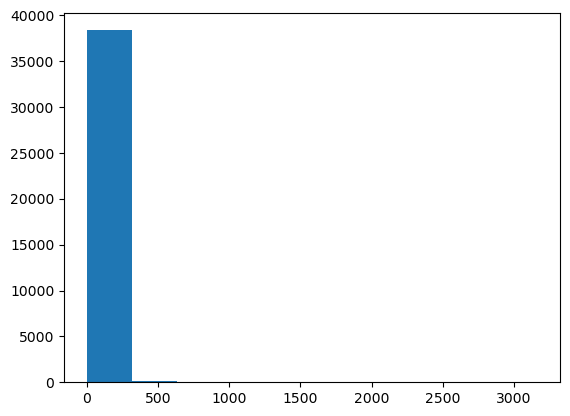

In [27]:
# Distribución de grado de la red

degrees = list(dict(G.degree()).values())
plt.hist(list(degrees))
plt.show()

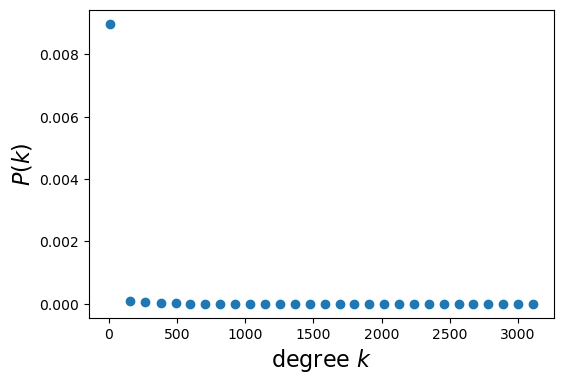

In [28]:
# Entrega 20 bins linealmente espaceados entre kmin y kmax
bin_edges = np.linspace(kmin1, kmax1, num=30)

# histograma de la data en estos bines 
density, _ = np.histogram(degrees1, bins=bin_edges, density=True)
###Histograma
fig = plt.figure(figsize=(6,4))

# "x" debería ser el punto medido (en escala lineal) de cada bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Muestra la gráfica
plt.show()

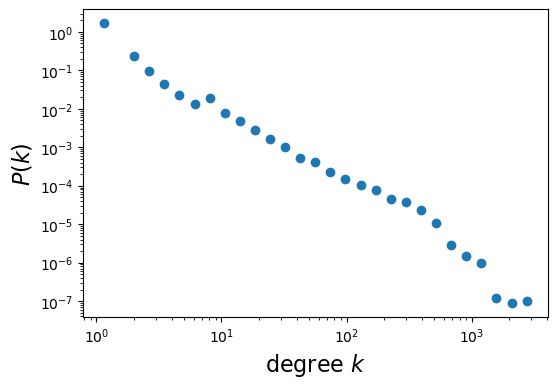

In [29]:
bin_edges = np.logspace(np.log10(kmin1), np.log10(kmax1), num=30)
density, _ = np.histogram(degrees1, bins=bin_edges, density=True)
np.histogram(degrees1, bins=bin_edges, density=True)

###Histograma
fig = plt.figure(figsize=(6,4))

# "x" debe ser el punto medio (en escala LOG) de cada bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Muestra la gráfica
plt.show()

El análisis mediante histogramas permite confirmar nuevamente que existe una gran cantidad de nodos poco conectados y que para grados mayores la distribución de nodos disminuye exponencialmente.

### Identificacion de Comunidades:

- Tal como era posible predecir debido a lo poco densa de la red, existe una cantidad significativa de comunidades.


- En este punto se ha optado por definir un random_state para la función de best_partition que arroje una partición con varias comunidades de baja cantidad de nodos, a fin de facilitar el análisis de las comunidades mediante algoritmos.

In [30]:
partition = community_louvain.best_partition(G, weight='weight', random_state = 6)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Se detectan 15 comunidades


Tamaño Comunidad 0: 3014
Tamaño Comunidad 1: 3273
Tamaño Comunidad 2: 7983
Tamaño Comunidad 3: 8138
Tamaño Comunidad 4: 52
Tamaño Comunidad 5: 70
Tamaño Comunidad 6: 4884
Tamaño Comunidad 7: 701
Tamaño Comunidad 8: 4515
Tamaño Comunidad 9: 2314
Tamaño Comunidad 10: 4
Tamaño Comunidad 11: 2926
Tamaño Comunidad 12: 732
Tamaño Comunidad 13: 5
Tamaño Comunidad 14: 6


### Nota:

###### Dado que correr el código nx.spring_layout(G) tarda demasiado tiempo, se ha generado un código que permite importar ya la disposición de nodos desde un archivo CSV.  

###### Se recomienda desactivar o eliminar los siguientes códicos si el programa ya ha sido ejecutado previamente y el archivo CSV ha sido generado, a fin de agilizar su ejecución:


- pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)
- pos_export = pd.DataFrame(pos)
- pos_export.to_csv('TareaFinalPos.csv')

In [31]:
pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)
pos_export = pd.DataFrame(pos)
pos_export.to_csv('TareaFinalPos.csv')
pos_import = pd.read_csv('TareaFinalPos.csv', sep=',')
#pos_import = pos_export
pos_import = pos_import.drop(['Unnamed: 0'], axis=1)
cord_dict = {}
for key in pos_import:
    cord = [pos_import[key][0], pos_import[key][1]]
    cord = np.array(cord)
    cord_dict[key] = cord
    
pos_import = cord_dict

In [32]:
#Posiciones definidas para los nodos
len(pos_import)

38617

In [33]:
#Verificacion de cantidad de nodos
len(lista_organismos)+len(lista_empresas)

38617

In [34]:
#Corroborar que la suma de cada nodo separado en als comunidades coincidan con la cantidad de nodos

sum = int()
for i in range(len(d)):
    sum = sum + len(d[i])
print (sum)

38617


#### Ploteo del Grafo

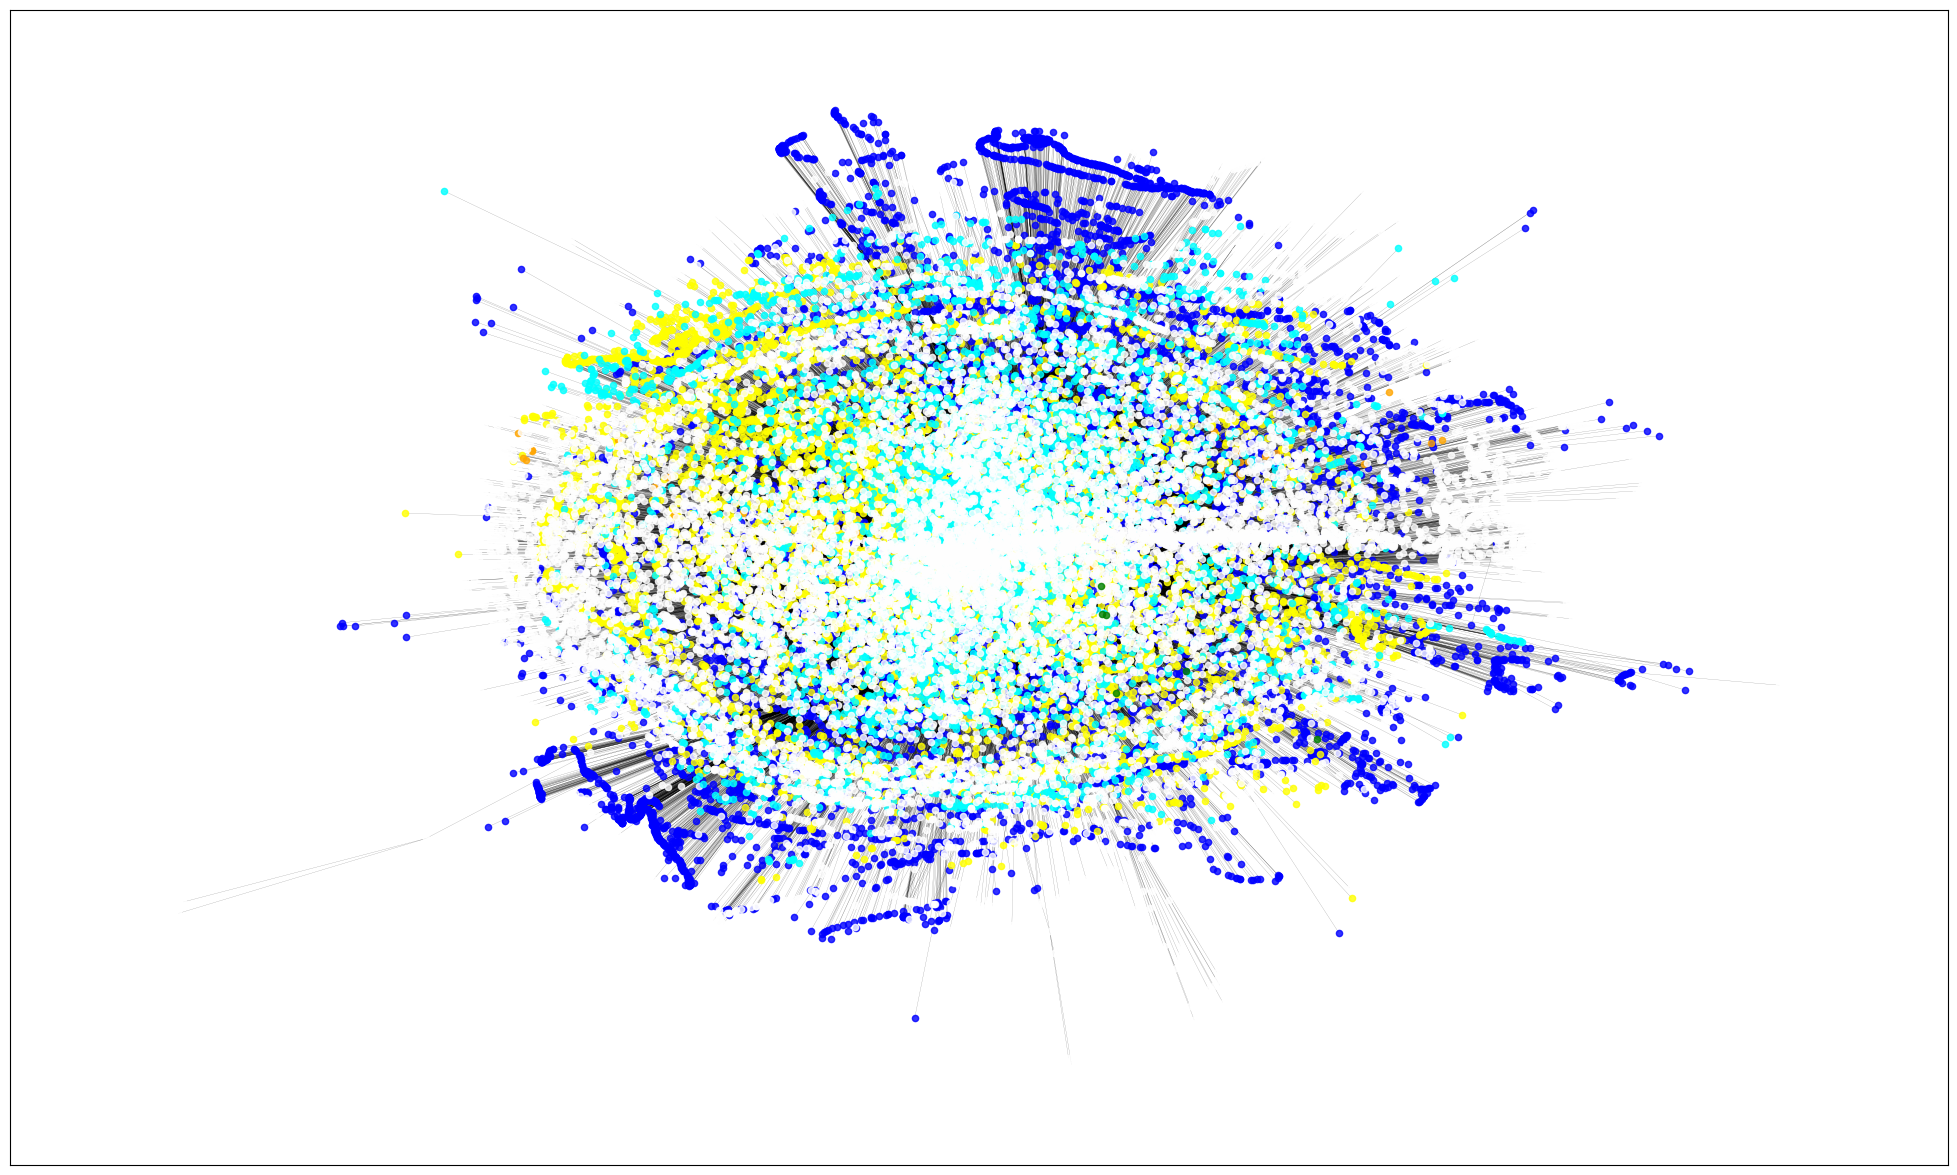

In [35]:
plt.figure(figsize=(25, 15))

#colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
colors = ['white', 'white', 'blue', 'yellow', 'orange', 'white', 'cyan', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'green', 'red', ]

count = 0
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos_import, list_nodes, node_size = 20, node_color=colors[count], alpha=0.8)#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores

nx.draw_networkx_edges(G, pos_import, alpha=0.5, width=0.15)#plotea enlaces
plt.show()


Mediante el gráfico de red es posible notar que si bien existen comunidades pequeñas que se notan aisladas en la periferia, se denota que las comunidades mas grandes no son facilmente separables entre si, por lo cual se deduce que la partición debe tener baja modularidad.

## Identificación de patrones de corrupción

In [36]:
# Funcion para crear lista de codigos de licitacion entre un par organismo-proveedor

def lista_empresa_licitacion(nombre_organismo, nombre_proveedor):
    
    df_ddn = df[['Codigo','NombreOrganismo','NombreProveedor','Oferta seleccionada']]
    df_ddn = df_ddn[(df_ddn['NombreProveedor'] == nombre_proveedor) ]
    
    lista_codigos = []

    for i in df_ddn['Codigo'].to_numpy():
        lista_codigos.append(i)
       
    return lista_codigos

# Funcion para conseguir el coeficiente de jaccard

def jaccard(grupo1, grupo2):
    interseccion = len(set(grupo1).intersection(set(grupo2)))
    union = len (set(grupo1).union(set(grupo2)))
    
    return interseccion / union , interseccion

# Funcion para conseguir el coeficiente de jaccard para todos los nodos dentro de una comunidad

def jaccard_completo(dd):
    
    lista_nombres_organismos = dd['NombreOrganismo']
    lista_nombres_proveedores = dd['NombreProveedor']
    
    dicc_codigos_dd = {}
    
    df = pd.DataFrame(columns=['NombreProveedor_1', 'NombreProveedor_2', 'Coeficiente de Jaccard', 'CantidadCoincidencias'])
    
    for i in range(len(dd)):
        lista_codigos = lista_empresa_licitacion(lista_nombres_organismos[i], lista_nombres_proveedores[i])
        
        dicc_codigos_dd[lista_nombres_proveedores[i]] = lista_codigos
                
    for key_j, value_j in dicc_codigos_dd.items():
        for key_k, value_k in dicc_codigos_dd.items():
            jacard_empresas, interseccion = jaccard(value_j, value_k)
            #print (f"Porcentaje de similitud Para Empresas {key_j} y {key_k} : {round(jacard_empresas,2)}")
            df_append = pd.DataFrame({'NombreProveedor_1': key_j, 'NombreProveedor_2': key_k,
                                      'Coeficiente de Jaccard': round(jacard_empresas,2), 'CantidadCoincidencias':interseccion }, index=[0])
            frames = [df, df_append]
            df = pd.concat(frames)
            
    df = df.sort_values(by='Coeficiente de Jaccard', ascending=False)
    df = df.reset_index().drop(columns='index')
    
    for index, row in df.iterrows():
        if row['NombreProveedor_1'] == row['NombreProveedor_2']:
            df = df.drop(index)
    df = df.reset_index().drop(columns='index')
    df2 = df
    for i in range(len(df2)):
        for k in range(i+1, len(df2)):
            
            if df2.NombreProveedor_1[i] == df2.NombreProveedor_2[k]: 
                if df2.NombreProveedor_1[k] == df2.NombreProveedor_2[i]:
                    df = df.drop(k)
        
    return df    

In [37]:
def comunidad(df, d):

    df2 = pd.DataFrame()
    j = 0
    for i in range (len(df)):
        if df.NombreOrganismo[i] in d:
            if j == 0:
                df2 = df.loc[i:i]
                j = 1
            else:
                df3 = df.loc[i:i]
                frames = [df2,df3]
                df2 = pd.concat(frames)
    df2 = df2.reset_index()
    
    j = 0
    for i in range (len(df2)):
        if df2.NombreProveedor[i] in d:
            if j == 0:
                df1 = df2.loc[i:i]
                j = 1
            else:
                df3 = df2.loc[i:i]
                frames = [df1,df3]
                df1 = pd.concat(frames)
    df1 = df1.reset_index()                        
    df1 = df1[['NombreOrganismo','NombreProveedor','Conteo Interacciones']]
    
    lista_tuplas_pesos = []
    for i in df1.to_numpy():
        lista_tuplas_pesos.append((i[0], i[1], i[2]))
    lista_tuplas_pesos[:4]

    G = nx.Graph()
    G.add_nodes_from(df1['NombreProveedor'].unique(), bipartite=0)
    G.add_nodes_from(df1['NombreOrganismo'].unique(),bipartite=1)
    G.add_weighted_edges_from(lista_tuplas_pesos)
    
    plt.figure(figsize=(10, 6))
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, d, node_size = 20, node_color=['red'], alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.8, width=0.25)

    plt.show()
            
    return df1, G

### Comunidad de estudio #1: Gobierno Regional de Atacama

Para esta comunidad se realizaron dos análisis: el primero mediante la representación gráfica de la red bipartita y la tabla de enlaces ponderados, para poder definir si existe algún tipo de vinculación entre el organismo licitador y las empresas proveedoras. El segundo es el cálculo del coeficiente de Jaccard, para identificar la razón de coincidencias entre las licitaciones en las que partipican los nodos de la comunidad.

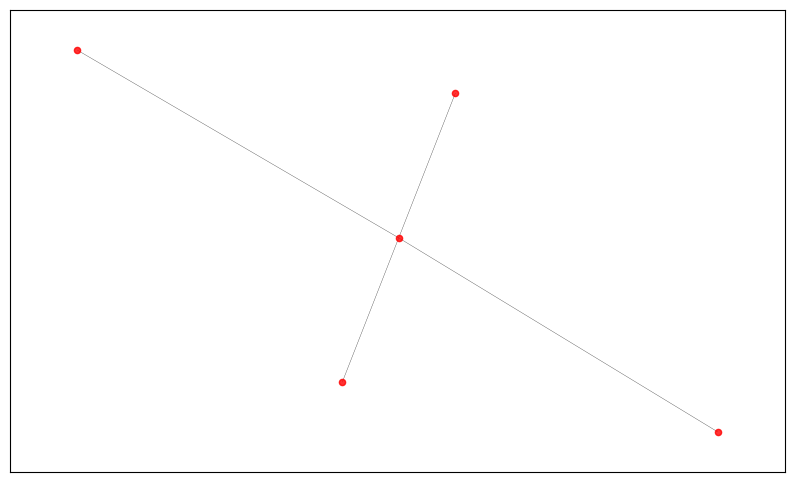

,NombreOrganismo,NombreProveedor,Conteo Interacciones
1,GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,11
2,GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,11
0,GOBIERNO REGIONAL DE ATACAMA,Aquapress Limitada,1
3,GOBIERNO REGIONAL DE ATACAMA,Zerega Y Cia. Ltda.,1


In [38]:
dd0,Gd0 = comunidad(pivot, d[13])
dd0.sort_values(by='Conteo Interacciones', ascending=False)

Es posible apreciar que existe una llamativa distribución en las particiones dentro de esta comunidad, donde un total de 25 paricipaciones en licitaciones corresponden a solo 2 códigos con un total de 12 OC emitidas.

In [39]:
df0 = df[df['NombreOrganismo'] == 'GOBIERNO REGIONAL DE ATACAMA']
df0 = df0[['Codigo','Tipo de Adquisicion','NombreOrganismo','NombreProveedor','MontoLineaAdjudica','Moneda de la Oferta']]
df0

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
475059,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,15000,Peso Chileno
475060,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475061,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475062,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,18000,Peso Chileno
475063,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,20000,Peso Chileno
475064,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475065,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475066,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,25000,Peso Chileno
475067,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,18000,Peso Chileno
475068,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno


In [40]:
df0[df0['Codigo']== 8748588]['MontoLineaAdjudica'].astype('int64', copy=False).sum()

355400

- Dentro de las 12 OC emitidas por el Gobierno Regional de Atacama, 11 son a "GYP TECNOLOGIA" con un valor total de $355.400, donde el proceso de licitación contó con solamente un oferente adicional.

- Respecto a la OC restante , en su proceso de licitación sólo participaron 3 oferentes y el proveedor adjudicado fue "Zerega y Cia.Ltda" por un monto de $19.800.000.

In [41]:
codigos = jaccard_completo(dd0)
codigos[codigos['CantidadCoincidencias']>0.9*codigos['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,Aquapress Limitada,Zerega Y Cia. Ltda.,1.0,1
2,Conecta Global Ltda.,GYP TECNOLOGIA,0.5,1


- Este indicador permite identificar que en el caso de "Aquapress Limitada" y "Zerega Y Cia. Ltda." dentro de los registros solo poseen una única participación en licitaciones y corresponde a la del Gobierno Regional de Atacama.


- Si bien ambos procesos de adjudicación parecen llamativos, en el caso de la licitación 8682225 adjudicada a "Zerega Y Cia. Ltda." es mucho más llamativo ya que por un lado la licitación posee muy pocos oferentes y 2 de ellos presentan solo una única participación lo cual podría ser indicio de colusión o de participantes que solo buscaban completar la terna para que la licitación no sea declarada desierta.

### Comunidad de estudio #2: Hospital Padre Alberto Hurtado

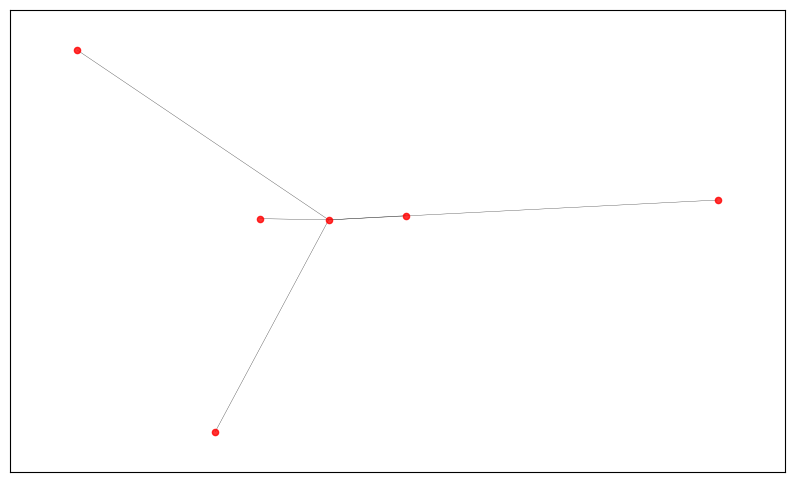

,NombreOrganismo,NombreProveedor,Conteo Interacciones
2,HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,64
3,HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,50
0,HOSPITAL PADRE ALBERTO HURTADO,AIR CENTRAL SPA,1
1,HOSPITAL PADRE ALBERTO HURTADO,APO Limitada,1
4,HOSPITAL PADRE ALBERTO HURTADO,barbara michele,1


In [42]:
dd1,Gd1 = comunidad(pivot, d[14])
dd1.sort_values(by='Conteo Interacciones', ascending=False)

In [43]:
codigos1 = jaccard_completo(dd1)
codigos1[codigos1['CantidadCoincidencias']>0.9*codigos1['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,barbara michele,APO Limitada,0.5,1
2,PAB Ingeniería,Valeska Solange,0.5,1


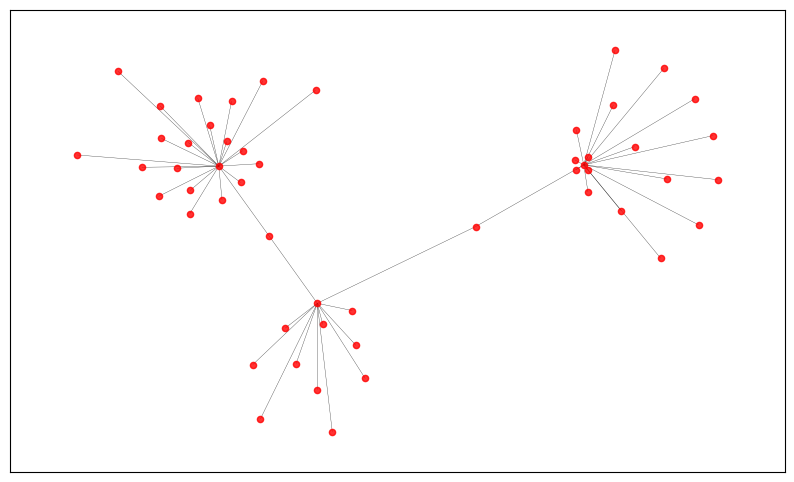

,NombreOrganismo,NombreProveedor,Conteo Interacciones
15,I MUNICIPALIDAD DE FREIRINA,ferrohogar,435
9,I MUNICIPALIDAD DE FREIRINA,Ferretería Lonza y Cía. Ltda.,380
5,I MUNICIPALIDAD DE FREIRINA,Carlos Carrasco,374
2,I MUNICIPALIDAD DE FREIRINA,BRENDA ARACELY,229
12,I MUNICIPALIDAD DE FREIRINA,Multy,21
40,SERVICIO DE SALUD NUBLE HOSPITAL DE QUIRIHUE,GUSTAVO GALLEGOS,18
33,I MUNICIPALIDAD DE HUALAIHUE,María José,16
20,I MUNICIPALIDAD DE HUALAIHUE,BRAULIO RODRIGO,16
43,SERVICIO DE SALUD NUBLE HOSPITAL DE QUIRIHUE,HECTOR HERNAN,15
34,I MUNICIPALIDAD DE HUALAIHUE,OLEA SERVICIOS SPA,15


In [44]:
dd2,Gd2 = comunidad(pivot, d[4])
dd2.sort_values(by='Conteo Interacciones', ascending=False)

In [45]:
codigos2 = jaccard_completo(dd2)
codigos2[codigos2['CantidadCoincidencias']>0.9*codigos2['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,BRAULIO RODRIGO,María José,1.00,2
6,BRAULIO RODRIGO,ALVEAL121,0.67,2
7,ALVEAL121,María José,0.67,2
26,Hugo,ENTEL CHILE S.A. - Gerencia Zonal Iquique,0.22,2
48,HECTOR HERNAN,El navegador,0.08,2


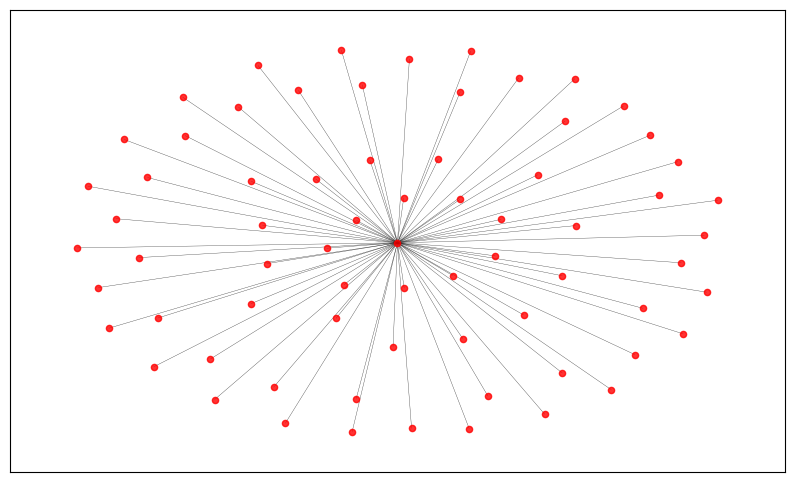

,NombreOrganismo,NombreProveedor,Conteo Interacciones
53,I MUNICIPALIDAD DE CHEPICA,VIDALFA LIMITADA,9
68,I MUNICIPALIDAD DE CHEPICA,transporte toledo,6
65,I MUNICIPALIDAD DE CHEPICA,juan alejandro,6
56,I MUNICIPALIDAD DE CHEPICA,ana carolina,6
51,I MUNICIPALIDAD DE CHEPICA,TURISANT,6
...,...,...,...
38,I MUNICIPALIDAD DE CHEPICA,Marcela Andrea,1
39,I MUNICIPALIDAD DE CHEPICA,Mariano Andres,1
40,I MUNICIPALIDAD DE CHEPICA,Monserrat francisca,1
9,I MUNICIPALIDAD DE CHEPICA,CardioHome,1


In [46]:
dd3,Gd3 = comunidad(pivot, d[5])
dd3.sort_values(by='Conteo Interacciones', ascending=False)

In [47]:
codigos3 = jaccard_completo(dd3)
codigos3[codigos3['CantidadCoincidencias']>0.9*codigos3['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
159,Ingeniería y Construcción Incorell,Constructora Santa Catalina,0.14,4
176,VIDALFA LIMITADA,Ingeniería y Construcción Incorell,0.12,4


### Comunidad de estudio #3: Caso MOSIL LIMITADA

In [48]:
df101 = df[df['NombreProveedor'] == 'MOSIL LIMITADA'][df['Oferta seleccionada']=='Seleccionada']
df101 = pd.pivot_table(df101, index=['NombreOrganismo','NombreProveedor'],values=['Oferta seleccionada'],aggfunc='count')
df101 = df101.reset_index().sort_values(by='Oferta seleccionada', ascending=False)
df101.rename(columns = {'Oferta seleccionada':'Conteo Seleccionados'}, inplace = True)
df101.head(15)

C:\Users\pablo\AppData\Local\Temp\ipykernel_27536\424500896.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df101 = df[df['NombreProveedor'] == 'MOSIL LIMITADA'][df['Oferta seleccionada']=='Seleccionada']


,NombreOrganismo,NombreProveedor,Conteo Seleccionados
8,I MUNICIPALIDAD DE LOTA,MOSIL LIMITADA,2045
11,I MUNICIPALIDAD DE SAN PEDRO DE LA PAZ,MOSIL LIMITADA,66
18,Ilustre Municipalidad de Lebu,MOSIL LIMITADA,36
21,MUNICIPALIDAD DE HUALPEN,MOSIL LIMITADA,34
5,I MUNICIPALIDAD DE CORONEL,MOSIL LIMITADA,12
12,I MUNICIPALIDAD DE SANTA BARBARA,MOSIL LIMITADA,11
17,Ilustre Municipalidad de Curanilahue,MOSIL LIMITADA,10
14,I MUNICIPALIDAD DE TOME,MOSIL LIMITADA,10
13,I MUNICIPALIDAD DE SANTA JUANA,MOSIL LIMITADA,5
15,I MUNICIPALIDAD DE YUMBEL,MOSIL LIMITADA,5


In [49]:
df102 = df[df['NombreOrganismo'] == 'I MUNICIPALIDAD DE LOTA']
lota = []

for i in df102['NombreProveedor'].unique():
    lota.append(i)
    
lota.append('I MUNICIPALIDAD DE LOTA')

In [50]:
lota

['Xavier Andres Lauriani Molina',
 'Global Construcciones Spa',
 'RAGLIANTI Y COMPAÑIA LIMITADA',
 'roddan soluciones integrales spa',
 'TERESA GARRIDO ROJAS E HIJOS LTDA',
 'FRANCISCO MANUEL',
 'Repuestos Hualqui',
 'GENIALCOM SPA',
 'SERVICIO TECNICO GILDEMEISTER',
 'Jose Luis Pavez y Cía Ltda - BOSCH Car Service',
 'FELIX OLEA',
 'Universal Diesel',
 'OLIMPO REPUESTOS',
 'RICARDO ENRIQUE',
 'DIARIO LA TRIBUNA',
 'SOCIEDAD RADIODIFUSORA FM 102 LIMITADA',
 'MULTICOMERCIAL CHILLAN LTDA CHILECOMPRAS',
 'marcelo',
 'MIG',
 'SERVICIOS HIMCE LIMITADA',
 'DK INGENIERIA Y CONSTRUCCION SPA',
 'eco sweep',
 'TOCONAO LTDA SOC. CORREDORA DE SEGUROS',
 'Hdi Seguros S.A. - Temuco',
 'Juan José González González',
 'Comercial Antuco',
 'Roanel',
 'Rehuce Ltda',
 'ORIETA ',
 'MULTICOMERCIAL CHILLAN',
 'XIMENA AYALA',
 'Distribuidora Seguel Limitada',
 'Roian Store',
 'Ana Valentina ',
 'Vanessa Hugo Osorio',
 'ORKIN CHILE',
 '79733881',
 'Sanidec Plagas Cía Ltda',
 'COMERCIALIZACIÓN',
 'JORGE ANDRÉS

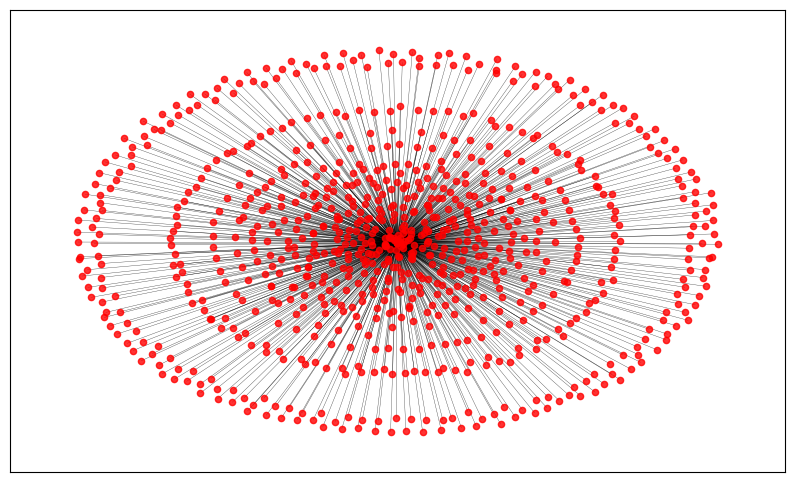

In [51]:
ddlota,G_lota = comunidad(pivot, lota)
ddlota = ddlota.sort_values(by='Conteo Interacciones', ascending=False)

In [52]:
ddlota.reset_index().drop(columns='index')

,NombreOrganismo,NombreProveedor,Conteo Interacciones
0,I MUNICIPALIDAD DE LOTA,MULTICOMERCIAL CHILLAN,4679
1,I MUNICIPALIDAD DE LOTA,MOSIL LIMITADA,3380
2,I MUNICIPALIDAD DE LOTA,Carlos Espejo y Cía. Ltda.-,919
3,I MUNICIPALIDAD DE LOTA,ElMINERITO,736
4,I MUNICIPALIDAD DE LOTA,HUALPEN,538
...,...,...,...
830,I MUNICIPALIDAD DE LOTA,Rodrigo Jose Romero Soto,1
831,I MUNICIPALIDAD DE LOTA,Rodrigo ariel,1
832,I MUNICIPALIDAD DE LOTA,Constanza Solá Pardo,1
833,I MUNICIPALIDAD DE LOTA,Comercializadora Raiper Chile SPA,1


In [53]:
dflota = df[df['NombreProveedor'] == 'MOSIL LIMITADA'][df['Oferta seleccionada']=='Seleccionada']
dflota

C:\Users\pablo\AppData\Local\Temp\ipykernel_27536\1517818614.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dflota = df[df['NombreProveedor'] == 'MOSIL LIMITADA'][df['Oferta seleccionada']=='Seleccionada']


,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
64671,8636708,Licitación Pública Menor a 100 UTM (L1),Adjudicada,111875,DIRECCION DE ABASTECIMIENTO DE LA ARMADA,61.102.023-6,Talcahuano,2020-01-08,31211904,76.722.635-7,MOSIL LIMITADA,Peso Chileno,29970,Seleccionada
64750,8636708,Licitación Pública Menor a 100 UTM (L1),Adjudicada,111875,DIRECCION DE ABASTECIMIENTO DE LA ARMADA,61.102.023-6,Talcahuano,2020-01-08,14111609,76.722.635-7,MOSIL LIMITADA,Peso Chileno,109035,Seleccionada
144707,8643081,Licitación Pública Menor a 100 UTM (L1),Adjudicada,98443,I MUNICIPALIDAD DE TOME,69.150.100-0,Tomé,2020-01-18,11111611,76.722.635-7,MOSIL LIMITADA,Peso Chileno,2945824,Seleccionada
175629,8645554,Licitación Pública Menor a 100 UTM (L1),Adjudicada,120004,I MUNICIPALIDAD DE YUMBEL,69.150.901-K,Yumbel,2020-01-23,31161504,76.722.635-7,MOSIL LIMITADA,Peso Chileno,798258,Seleccionada
184016,8646299,Licitación Pública Menor a 100 UTM (L1),Adjudicada,123786,MUNICIPALIDAD DE HUALPEN,69.264.400-k,Hualpén,2020-01-24,11111701,76.722.635-7,MOSIL LIMITADA,Peso Chileno,54750,Seleccionada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868145,8729648,Licitación Pública Menor a 100 UTM (L1),Adjudicada,113259,I MUNICIPALIDAD DE LOTA,69.151.300-9,Lota,2020-09-30,22101505,76.722.635-7,MOSIL LIMITADA,Peso Chileno,29080,Seleccionada
1868147,8729648,Licitación Pública Menor a 100 UTM (L1),Adjudicada,113259,I MUNICIPALIDAD DE LOTA,69.151.300-9,Lota,2020-09-30,26111601,76.722.635-7,MOSIL LIMITADA,Peso Chileno,40712,Seleccionada
1868150,8729648,Licitación Pública Menor a 100 UTM (L1),Adjudicada,113259,I MUNICIPALIDAD DE LOTA,69.151.300-9,Lota,2020-09-30,30111601,76.722.635-7,MOSIL LIMITADA,Peso Chileno,48150,Seleccionada
1868574,8729695,Licitación Pública Entre 100 y 1000 UTM (LE),Adjudicada,100049,I MUNICIPALIDAD DE AYSEN,69.240.100-K,Aysén,2020-09-28,30111501,76.722.635-7,MOSIL LIMITADA,Peso Chileno,15500800,Seleccionada


In [54]:
ddlota_aux = ddlota.iloc[:10]
ddlota_aux = ddlota_aux.reset_index().drop(columns='index')
codigos123 = jaccard_completo(ddlota_aux)
codigos123[codigos123['CantidadCoincidencias']>0.001*codigos123['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,WINPHARM,ETHON PHARMACEUTICALS SPA.,0.59,3271
2,ETHON PHARMACEUTICALS SPA.,Caribean Pharma Ltda,0.56,3442
4,ETHON PHARMACEUTICALS SPA.,DROGUERIA GLOBAL PHARMA SPA,0.54,3162
6,DROGUERIA GLOBAL PHARMA SPA,Caribean Pharma Ltda,0.52,2884
8,DROGUERIA GLOBAL PHARMA SPA,WINPHARM,0.50,2579
10,Caribean Pharma Ltda,Distribuidora Salcobrand,0.49,2586
12,WINPHARM,Caribean Pharma Ltda,0.48,2691
14,Distribuidora Salcobrand,ETHON PHARMACEUTICALS SPA.,0.46,2661
16,DROGUERIA GLOBAL PHARMA SPA,Distribuidora Salcobrand,0.43,2214
18,WINPHARM,Distribuidora Salcobrand,0.41,2085


La empresa MOSIL LIMITADA no tiene un coeficiente de Jaccard alto, por lo que dentro de la Municipalidad de Lota está bien distribuida, sin embargo, es llamativo que la tasa de éxito en esta empresa sea tan alto.

## Conclusiones, trabajos futuros y limitaciones

### Conclusiones

- Las empresas farmaceuticas son el giro el cual concentra la mayor cantidad de licitaciones en el año 2020.


- Se esperaba que hubieran mas instituciones de salud en los organismos que abrieron licitaciones, pero este top lo lideran instituciones de fuerzas armadas.


- Se analizó la tasa de éxito de los proveedores, encontrando una distribución sospechosa entre el top 7 y que la empresa MOSIL es potencialmente fraudulenta.


- Se construyó una red bipartita con 38.617 nodos y 205.391 enlaces.


- Observando la distribución de grado, se ve que gran cantidad de nodos bajamente conectados y que para grados mayores la distribución de nodos disminuye exponencialmente.


- El cálculo de comunidades mediante el algoritmo de Louvain es una excelente herramienta para detectar posibles casos de corrupción. Se estudiaron las comunidades más pequeñas encontrando anomalías importantes en cuanto a los criterios de selección de proveedores por parte los organismos.


- El coeficiente de Jaccard es también un buen indicador el cual muestra cuantas veces coincidieron los mismos proveedores en las licitaciones. Si el coeficiente es bajo, significa que un proveedor está postulando de manera aislada a las licitaciones sin competir.


- En el caso de estudio de Atacama, todos los participantes tienen un alto coef Jaccard entre sí. Los ganadores tienen un coef Jaccard bajo sugiriendo que estas empresas no competían.


- En el caso de MOSIL LIMITADA, quien destaca por su gran cantidad de licitaciones aceptadas (comparables con empresas farmacéuticas de renombre) y una de las tasas de éxito postulación/aceptación mas altas de todos los proveedores, concentra en la Municipalidad de Lota 2.000 licitaciones aceptadas, siendo esto una anomalía importante comparándolo con el general del dataset. Al calcular su Coeficiente de Jaccard, el grupo se percató de que coincide en licitaciones con la empresa Salcobrand, siendo MOSIL una empresa de construcción.


- La comunidad del Hospital Padre Hurtado era pequeña pero al analizarse no identificamos patrones de fraude.


- Se concluye que el desafío fue correctamente superado al haber finalizado cada una de las etapas solicitadas con éxito.


- Resulta muy positivo que la actividad final de esta asignatura contemple el desarrollo de un proyecto real, poniendo en práctica las herramientas adquiridas en esta esta asignatura y también en el magister.


### Trabajos futuros

- Existe una oportunidad al automatizar las tareas de análisis manual efectuadas durante este desafío.


- Una actividad para profundizar esta investigación, sería repetir el análisis desarrollado tomando en cuenta las comunidades mas grandes y descomponiendolas en sub-comunidades mas pequeñas, para así poder ir identificando patrones de corrupción de manera cíclica.


### Limitaciones

- La capacidad computacional enletece los análisis y lo hace en algunos casos imposible debido a la gran cantidad de ram necesaria para procesar esta red


- La cantidad de tiempo óptima para realziar un análisis realmente profundo de la base de datos es mayor a la que el grupo tuvo para finalizar el desafío.


### Bibliografía y Webgrafía

- https://www.mercadopublico.cl/Home/Contenidos/QueEsLicitacion
- https://www.cnmc.es/guias
- https://www.ciperchile.cl/2015/08/11/el-fraude-que-oscurece-las-licitaciones-que-gano-lg-para-iluminar-seis-comunas-con-led/
- https://www.elmostrador.cl/noticias/pais/2023/01/14/a-7-anos-del-milicogate-las-agencias-de-viajes-involucradas-se-adjudican-millonarias-licitaciones-con-el-estado/